In [1]:
import geemap
import geopandas as gpd
import pandas as pd
import ee
import os
import plotly.express as px
from sliderule import icesat2
import sliderule
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
os.environ["PLANET_API_KEY"] = "722017f6234b4160aa8d26fc6d39fa31"

ee.Initialize()
Map = geemap.Map()
Map.add_planet_by_month(year=2023, month=10)
avdf = gpd.read_file("/Users/jakegearon/PycharmProjects/NatureGeoSubmission/rebirth/data_to_submit.geojson")
avdf.crs = 'epsg:4326'
avdf = avdf.dropna(subset=['geometry'])
avulsion_fc = geemap.geopandas_to_ee(avdf)
vis_params_avulsion_fc = {
    'color': '#FFFF8D', 
    'pointSize': 10  
}
Map.addLayer(avulsion_fc, vis_params_avulsion_fc, "Avulsion Dataset")
Map.add_legend(legend_keys=["Avulsion Location"], legend_colors=['F44336'], position='bottomright')
Map.add_labels(
    avulsion_fc,
    "Avulsion Name",
    font_size="8pt",
    font_color="white",
    font_family="arial",
    font_weight="normal",
)

gdp_ppp = ee.Image("projects/sat-io/open-datasets/GRIDDED_HDI_GDP/GDP_PPP_1990_2015_5arcmin_v2")

Map.addLayer(ee.FeatureCollection('users/tedlanghorst/SWORD_node_v09'), {"color":"green"}, "SWORD", shown=False)
fabdem = ee.ImageCollection("projects/sat-io/open-datasets/FABDEM").mosaic().reproject("EPSG:4326")
srtm = ee.Image("USGS/SRTMGL1_003") # 2000-02-11T00:00:00Z - 2000-02-22T00:00:00
srtm = ee.Image("CGIAR/SRTM90_V4")
alos = ee.ImageCollection("JAXA/ALOS/AW3D30/V3_2").select("DSM").mosaic().setDefaultProjection('EPSG:4326',None,30) # 2006-01-24T00:00:00Z - 2011-05-12T00:00:00
gtopo = ee.Image("USGS/GTOPO30") #1996-01-01T00:00:00Z - 1996-01-01T00:00:00
aster = ee.Image("projects/sat-io/open-datasets/ASTER/GDEM");
fabdem = ee.ImageCollection("projects/sat-io/open-datasets/FABDEM")
fabdem = fabdem.mosaic().setDefaultProjection('EPSG:4326' , None ,30)
glo30 = ee.ImageCollection("projects/sat-io/open-datasets/GLO-30")
glo30 = glo30.mosaic().setDefaultProjection('EPSG:4326', None , 30)
merit = ee.Image("MERIT/DEM/v1_0_3")

Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

No such comm: 14449647b43442a99eba35bcf4c65ea1


In [11]:
elevation = fabdem
line = Map.draw_last_feature
leng = line.length(maxError=10).getInfo()
transect = geemap.extract_transect(elevation, line.geometry(), n_segments=np.floor(leng/30))
df = geemap.ee_to_pandas(transect)
# Define the base path and current identifier
base_path = "/Users/jakegearon/PycharmProjects/NatureGeoSubmission/avulsion_data/final_avulsion_data"
cur = "B12"

# Construct the path and load the line feature
path = os.path.join(base_path, f"{cur}/{cur}_val_transect.csv")
df.to_csv(path)

# save line
path_gdf = os.path.join(base_path, f"{cur}/{cur}_val.geojson")
geemap.ee_to_geopandas(transect).to_file(path_gdf, driver="GeoJSON")





In [12]:
#plot
df = 
px.line(df, x="distance", y="mean", title='Elevation Profile')

In [13]:
#cur = "MAHAJAMBA_2004"
#df_sr = gpd.read_feather(f'/Users/jakegearon/PycharmProjects/NatureGeoSubmission/avulsion_data/final_avulsion_data/{cur}/{cur}_data_UID_93.feather')
df_sr = gpd.read_feather(f'/Users/jakegearon/PycharmProjects/NatureGeoSubmission/avulsion_data/final_avulsion_data/BETSIBOKA_2004/BETSIBOKA_2004_UID_21.feather')
#df_sr = gpd.read_file('/Users/jakegearon/PycharmProjects/NatureGeoSubmission/avulsion_data/final_avulsion_data/CASP1_1991/CASP1_1991_UID_29.gpkg')

temp_df_pre = df_sr#df_sr.query("UID == {}".format(UID)).reset_index()
temp_df_pre = temp_df_pre[temp_df_pre['atl03_cnf'] >= 2]
temp_df_pre["along_track"] = temp_df_pre["along_track"] - temp_df_pre["along_track"].min()
graph = px.scatter(temp_df_pre, x="along_track", y="height").update_traces(marker={"size":3})
graph

In [9]:
roi = Map.draw_last_feature

# Create an image collection of Landsat 8 Surface Reflectance
collection = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2")
#collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
#

# Filter the collection by date, region, and cloud cover
collection = collection.filterDate('2013-01-01', '2014-09-28') \
                       .filterBounds(roi.geometry()) \
                       .filter(ee.Filter.lt('CLOUD_COVER', 10))

# Get the first image from the collection
image = collection.median()

# Applies scaling factors.
def applyScaleFactors(image):
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBand = image.select('ST_B6').multiply(0.00341802).add(149.0)
    return image.addBands(opticalBands, None, True) \
              .addBands(thermalBand, None, True)

# def applyScaleFactors(image):
#     opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
#     thermalBand = image.select('ST_B.*').multiply(0.00341802).add(149.0)
#     return image.addBands(opticalBands, None, True) \
#               .addBands(thermalBand, None, True)

image = applyScaleFactors(image)
# Display the image on the map
Map.addLayer(image, {'bands': ['SR_B3', 'SR_B2', 'SR_B1'], 'min': 0, 'max': .3}, 'Landsat')
#Map.addLayer(image, {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': .3}, 'Landsat')
Map.addLayer(ee.FeatureCollection('users/tedlanghorst/SWORD_node_v09'), {"color":"green"}, "SWORD", shown=False)



In [31]:
image

In [330]:
elevation = fabdem
line = Map.draw_last_feature
leng = line.length(maxError=10).getInfo()
transect = geemap.extract_transect(elevation, line.geometry(), n_segments=np.floor(leng/20), reducer='mean', to_pandas=True)
geemap.ee_to_geojson(line, f"/Users/jakegearon/PycharmProjects/NatureGeoSubmission/rebirth/MAHAJAMBA_avpath.geojson")
transect.to_csv(f"/Users/jakegearon/PycharmProjects/NatureGeoSubmission/rebirth/JA26_avpathN.csv")

In [3]:
elevation = glo30
roi = Map.draw_last_feature
clipped_elev = elevation.clip(roi.geometry())

geemap.ee_export_image(
    clipped_elev, filename="LIBYA_DERNA_GLO.tif", scale=30, region=roi.geometry(), file_per_band=False
,)

Generating URL ...
Please wait ...
Data downloaded to /Users/jakegearon/PycharmProjects/NatureGeoSubmission/rebirth/LIBYA_DERNA_GLO.tif


In [2]:
import pandas as pd
roi = Map.draw_last_feature
polygon = geemap.ee_to_gdf(ee.FeatureCollection(roi))
#sliderule.init()
region = sliderule.toregion(polygon)
parms = {"poly": region['poly'], "srt": 0, "cnf": 0,}
         # "atl08_class": ["atl08_ground", "atl08_canopy", "atl08_top_of_canopy"]}


# Build ATL06 Request
# parms = {
#     "poly": region['poly'],
#     "srt": [icesat2.SRT_LAND, icesat2.SRT_INLAND_WATER],
#     "len": 20.0,
#     "res": 10.0,
#     "maxi": 1,
#     "cnf": 2,
#     #"atl08_class": ["atl08_ground"]
# }

rsps = sliderule.icesat2.atl03sp(parms)
# analyze response and turn it into a geodataframe
# print(rsps)
# ######FOR ATL06
# df_sr = gpd.GeoDataFrame(rsps)
# if len(df_sr) == 0:
#     raise RuntimeError("No results returned, try a larger area!")
# # print length of final dataframe
# print("Length of returned GeoDataFrame: ", len(df_sr))
# g = df_sr.groupby(['rgt', 'cycle', 'spot', 'gt'])
# p = 1
# df_list = []
# for k, v in g:
#     v['lon'] = v.geometry.x
#     v['lat'] = v.geometry.y
#     v['along_track'] = v['distance']-v['distance'].min()
#     v = v.reset_index()
#     v['UID'] = p
#     v = gpd.GeoDataFrame(v, geometry = gpd.points_from_xy(x = v['lon'], y = v['lat'], crs="epsg:4326"))
#     if len(v) > 5:
#         df_list.append(v)
#         p += 1
# icesat_gdf = pd.concat(df_list)
# icesat_gdf.crs = "epsg:4326"

#### for ATL03
#### for ATL03
df_sr = gpd.GeoDataFrame(rsps)
if len(df_sr) == 0:
    raise RuntimeError("No results returned, try a larger area!")
# print length of final dataframe
print("Length of returned GeoDataFrame: ", len(df_sr))
# df_sr = df_sr.query("atl08_class == 1")
# let's add some columns
df_sr['lat'] = df_sr.geometry.y  # lat col
df_sr['lon'] = df_sr.geometry.x  # lon col

# let's add a unique identifier (UID) and calculate along-track distances
min_d = df_sr.segment_dist.min()
df_sr['UID'] = df_sr.groupby(['rgt', 'cycle', 'track', 'pair']).ngroup().add(1)
df_sr['along_track'] = (((df_sr["segment_dist"] + df_sr["distance"])) - min_d) - \
                       (((df_sr["segment_dist"] + df_sr["distance"])) - min_d)[0]
icesat_gdf = df_sr.reset_index()

KeyError: 'data'

In [5]:
import plotly.io as pio
pio.renderers.default = "browser"
subsample = icesat_gdf.groupby("UID").sample(frac=0.1)


fig = px.scatter_mapbox(subsample,
                        lat="lat",
                        lon="lon",
                        hover_name="height",
                        color="height",
                        hover_data=["height", "lat", "lon", "along_track", "UID", "time"],
                        height=500)
fig.update_layout(
        mapbox_style="white-bg",
        mapbox_layers=[
            {
                "below": "traces",
                "sourcetype": "raster",
                "sourceattribution": "Planet",
                "source": [
                    #"https://tiles0.planet.com/basemaps/v1/planet-tiles/global_monthly_%s_%s_mosaic/gmap/{z}/{x}/{y}.png?api_key=722017f6234b4160aa8d26fc6d39fa31" % (year, month)
                    "https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}"
                ]
            }])
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [8]:
UID = 61
temp_df_pre = icesat_gdf.query("UID == {}".format(UID)).reset_index()
temp_df_pre = temp_df_pre[temp_df_pre['atl03_cnf'] > 1]
#temp_df_pre["along_track"] = temp_df_pre["along_track"] - temp_df_pre["along_track"].min()
graph = px.scatter(temp_df_pre, x="along_track", y="height").update_traces(marker={"size":3})
graph


In [38]:
temp_df_pre.columns
3

Index(['index', 'time', 'background_rate', 'segment_id', 'segment_dist',
       'sc_orient', 'cycle', 'solar_elevation', 'track', 'rgt', 'atl03_cnf',
       'snowcover', 'relief', 'landcover', 'quality_ph', 'atl08_class',
       'height', 'distance', 'yapc_score', 'pair', 'geometry', 'spot', 'lat',
       'lon', 'UID', 'along_track'],
      dtype='object')

In [169]:
temp_df_pre.to_feather('/Users/jakegearon/PycharmProjects/NatureGeoSubmission/avulsion_data/final_avulsion_data/JA_30_Eritrea_2007_2007/JA_30_Eritrea_data_UID_34.feather')
icesat_gdf.to_feather('/Users/jakegearon/PycharmProjects/NatureGeoSubmission/avulsion_data/final_avulsion_data/JA_30_Eritrea_2007_2007/JA_30_Eritrea_data.feather')


In [85]:
#icesat_gdf.to_feather("/Users/jakegearon/PycharmProjects/PhD Advancement/kaz.feather")
temp_df_pre.to_csv(f"/Users/jakegearon/PycharmProjects/NatureGeoSubmission/avulsion_data/{name}/{name}_ICESAT_{UID}_{number}.csv")

In [93]:
line = Map.draw_last_feature
geemap.ee_to_geojson(line, f"/Users/jakegearon/PycharmProjects/NatureGeoSubmission/rebirth_JA_12_Eritrea_avpath.geojson")


## Alluvial Ridge Slope

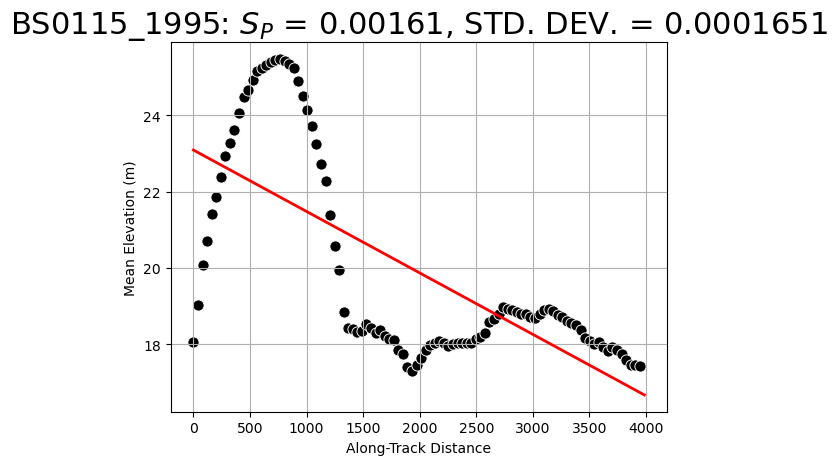

In [8]:
name = "BS0115_1995"
elevation = fabdem
number = 1
line = Map.draw_last_feature
leng = line.length(maxError=10).getInfo()
transect = geemap.extract_transect(elevation, line.geometry(), n_segments=np.floor(leng/40), reducer='mean', to_pandas=True)

try:
    sns.scatterplot(data=transect, x='distance', y='mean', s=65, color='k')
    x = transect['distance']
    y = transect['mean']
    p, V = np.polyfit(x, y, 1, cov=True)
    err = np.sqrt(V[0][0])
    new_x = np.linspace(x.min(), x.max(), len(x))
    new_y = np.polyval(p, new_x)
    plt.plot(new_x, new_y, 'r-', lw=2)
    mae = mean_absolute_error(y, new_y) / leng
except ValueError:
    y = y.interpolate('linear')
    p, V = np.polyfit(x, y, 1, cov=True)
    err = np.sqrt(V[0][0])
    new_x = np.linspace(x.min(), x.max(), len(x))
    new_y = np.polyval(p, new_x)
    plt.plot(new_x, new_y, 'r-', lw=2)

slope = np.abs(p[0])
plt.title('{}: $S_P$ = {}, STD. DEV. = {}'.format(name, round(slope, 5), round(err, 7)), fontsize=22)
plt.ylabel('Mean Elevation (m)')
plt.xlabel('Along-Track Distance')
#plt.savefig(p_plotpath, dpi=100)
plt.grid(which='both', axis='both')
plt.show()


In [336]:
sr = .00215
sc = .00013
sr/sc

16.53846153846154

In [343]:
.00566/.0087

0.6505747126436782

In [353]:
.002/.01

0.2

In [60]:
geemap.ee_to_geojson(line, f"/Users/jakegearon/PycharmProjects/NatureGeoSubmission/avulsion_data/{name}/{name}_XV_{number}.geojson")
transect.to_csv(f"/Users/jakegearon/PycharmProjects/NatureGeoSubmission/avulsion_data/{name}/{name}_XV_{number}.csv")


## Parent Slope

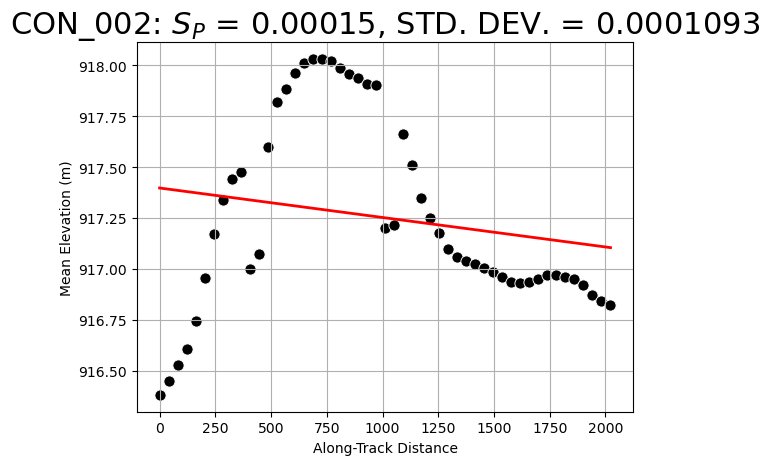

In [74]:
elevation = fabdem
number = 3
line = Map.draw_last_feature
leng = line.length(maxError=10).getInfo()
transect = geemap.extract_transect(elevation, line.geometry(), n_segments=np.floor(leng/40), reducer='mean', to_pandas=True)

try:
    sns.scatterplot(data=transect, x='distance', y='mean', s=65, color='k')
    x = transect['distance']
    y = transect['mean']
    p, V = np.polyfit(x, y, 1, cov=True)
    err = np.sqrt(V[0][0])
    new_x = np.linspace(x.min(), x.max(), len(x))
    new_y = np.polyval(p, new_x)
    plt.plot(new_x, new_y, 'r-', lw=2)
    mae = mean_absolute_error(y, new_y) / leng
except ValueError:
    y = y.interpolate('linear')
    p, V = np.polyfit(x, y, 1, cov=True)
    err = np.sqrt(V[0][0])
    new_x = np.linspace(x.min(), x.max(), len(x))
    new_y = np.polyval(p, new_x)
    plt.plot(new_x, new_y, 'r-', lw=2)

slope = np.abs(p[0])
plt.title('{}: $S_P$ = {}, STD. DEV. = {}'.format(name, round(slope, 5), round(err, 7)), fontsize=22)
plt.ylabel('Mean Elevation (m)')
plt.xlabel('Along-Track Distance')
#plt.savefig(p_plotpath, dpi=100)
plt.grid(which='both', axis='both')
plt.show()


In [64]:
geemap.ee_to_geojson(line, f"/Users/jakegearon/PycharmProjects/NatureGeoSubmission/avulsion_data/{name}/{name}_S_{number}.geojson")
transect.to_csv(f"/Users/jakegearon/PycharmProjects/NatureGeoSubmission/avulsion_data/{name}/{name}_S_{number}.csv")


## Superelevation Viz

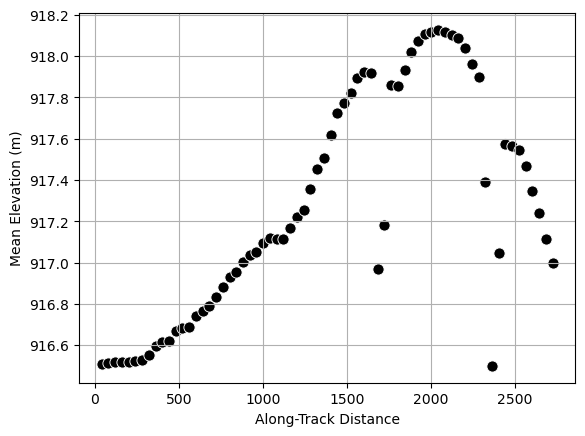

In [72]:
elevation = fabdem
number = 2
line = Map.draw_last_feature
leng = line.length(maxError=10).getInfo()
transect = geemap.extract_transect(elevation, line.geometry(), n_segments=np.floor(leng/40), reducer='mean', to_pandas=True)

min_value = 1
max_value = 10000
transect_cropped = transect.loc[transect['distance'] > min_value]
transect_cropped = transect_cropped.loc[transect_cropped['distance'] < max_value]

sns.scatterplot(data=transect_cropped, x='distance', y='mean', s=65, color='k')
x = transect_cropped['distance']
y = transect_cropped['mean']

plt.ylabel('Mean Elevation (m)')
plt.xlabel('Along-Track Distance')
#plt.savefig(p_plotpath, dpi=100)
plt.grid(which='both', axis='both')
plt.show()


In [73]:
geemap.ee_to_geojson(line, f"/Users/jakegearon/PycharmProjects/NatureGeoSubmission/avulsion_data/{name}/{name}_beta_{number}.geojson")
transect.to_csv(f"/Users/jakegearon/PycharmProjects/NatureGeoSubmission/avulsion_data/{name}/{name}_beta_{number}.csv")

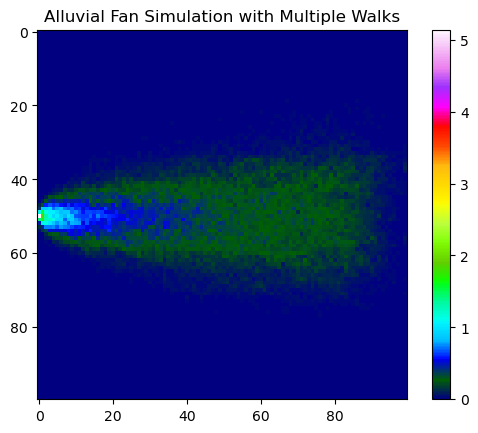

In [251]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
grid_size = 100
num_steps_per_walk = 150
num_walks = 500
deposition_rate = .01
avulsion_threshold = 1.0
slope_weight = 1

# Initialize the grid
grid = np.zeros((grid_size, grid_size))

# Execute multiple walks
for _ in range(num_walks):
    perform_walk(grid_size // 2, 0)

# Visualization
plt.imshow(grid, cmap="gist_ncar")
plt.colorbar()
plt.title("Alluvial Fan Simulation with Multiple Walks")
plt.show()


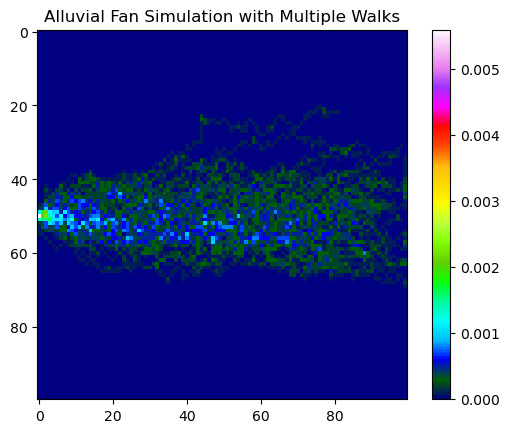

In [289]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax as scipy_softmax


def compute_movement_probs(x, y, last_vector, neighbors, elevation, theta, alpha, beta):
    neighbor_slopes = [calculate_slope(elevation, (x, y), (nx, ny)) for nx, ny in neighbors]

    momentum_weights = []
    for nx, ny in neighbors:
        direction = np.array([nx - x, ny - y])
        normalized_last_vector = last_vector / np.linalg.norm(last_vector) if np.linalg.norm(last_vector) > 0 else np.array([1, 0])  # defaulting to [1, 0] as a sample normalized vector
        normalized_direction = direction / np.linalg.norm(direction)
        cosine_similarity = np.dot(normalized_last_vector, normalized_direction)
        momentum_weight = alpha * (1 + cosine_similarity) / 2
        momentum_weights.append(momentum_weight)
    momentum_weights = np.array(momentum_weights)



    slope_weights = [theta * slope for slope in neighbor_slopes]

    # Combine the weights directly without applying softmax to them individually
    combined_weights_raw = (1 - beta) * momentum_weights + beta * np.array(slope_weights)


    # Reshape the combined_weights_raw to be truly 1D before softmax
    reshaped_weights = combined_weights_raw.reshape(-1)
    combined_weights = scipy_softmax(reshaped_weights)

    # Check and normalize if necessary
    if np.isnan(np.sum(combined_weights)):
        combined_weights = np.array([1 / len(neighbors) for _ in neighbors])
    else:
        combined_weights /= np.sum(combined_weights)

    return combined_weights



def calculate_slope(elevation, current, neighbor, no_data_value=9999):
    current_elevation = elevation[current]
    neighbor_elevation = elevation[neighbor]

    if np.ma.is_masked(current_elevation) or np.ma.is_masked(neighbor_elevation):
        return np.NINF

    if current_elevation == no_data_value or neighbor_elevation == no_data_value:
        return np.NINF

    dx = abs(current[0] - neighbor[0])
    dy = abs(current[1] - neighbor[1])

    # using precalculated values for distances
    distance = np.sqrt(2) if dx == dy else 1

    rise = current_elevation - neighbor_elevation

    if np.isnan(rise):
        return np.NINF

    slope = rise / distance

    if np.isinf(slope):
        return np.copysign(np.inf, slope)

    return slope

def perform_walk(x, y, theta, alpha, beta):
    last_vector = np.array([1, 0])  # start with a default vector
    
    for _ in range(num_steps_per_walk):
        # Get the neighboring cells
        neighbors = [(x+dx, y+dy) for dx, dy in [(-1, 0), (1, 0), (0, 1), (-1, 1), (1, 1)]]

        # Remove neighbors that are out of grid bounds
        neighbors = [(nx, ny) for nx, ny in neighbors if 0 <= nx < grid_size and 0 <= ny < grid_size]
        
        # Ensure there are valid neighbors to move to
        if not neighbors:
            return

        # Use compute_movement_probs to get probabilities
        probs = compute_movement_probs(x, y, last_vector, neighbors, grid, theta, alpha, beta)

        # Decide on new direction
        chosen_avulsion = np.random.choice(len(neighbors), p=probs)
        nx, ny = neighbors[chosen_avulsion]

        # Deposit sediment on the CURRENT position
        grid[x, y] += deposition_rate

        # Update x, y and last_vector for the next iteration
        last_vector = np.array([nx - x, ny - y])
        x, y = nx, ny

# Define parameters
grid_size = 100
num_steps_per_walk = 150
num_walks = 50
deposition_rate = .0001
avulsion_threshold = .4
theta = 2
alpha = 1
beta = .5
# Initialize the grid
grid = np.zeros((grid_size, grid_size))

# Execute multiple walks
for _ in range(num_walks):
    perform_walk(grid_size // 2, 0, theta, alpha, beta)

# Visualization
plt.imshow(grid, cmap="gist_ncar")
plt.colorbar()
plt.title("Alluvial Fan Simulation with Multiple Walks")
plt.show()


In [212]:

chosen_avulsion = np.random.choice(len(neighbors), p=probs)


ValueError: a must be greater than 0 unless no samples are taken